In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Polygon, MultiPolygon, Point
import numpy as np

In [ ]:
# url = 'https://maps.wikimedia.org/geoshape?getgeojson=1&ids=Q14448'

In [19]:
lake_morat = gpd.read_file("lake_morat_polygon.geojson")

# remove all holes from the MultiPolygons
# geometry = lake_morat.geometry[0]
# outer_polygons = [Polygon(poly.exterior) for poly in geometry.geoms]
# single_polygon_no_holes = gpd.GeoSeries(outer_polygons).unary_union
# lake_morat = gpd.GeoDataFrame(geometry=[single_polygon_no_holes], crs=lake_morat.crs)

print("Area of Lake Morat:", lake_morat.to_crs(epsg=2056).area[0]/10**6, "km²") # EPSG:2056 is the Swiss projection

Area of Lake Morat: 22.497435213862826 km²


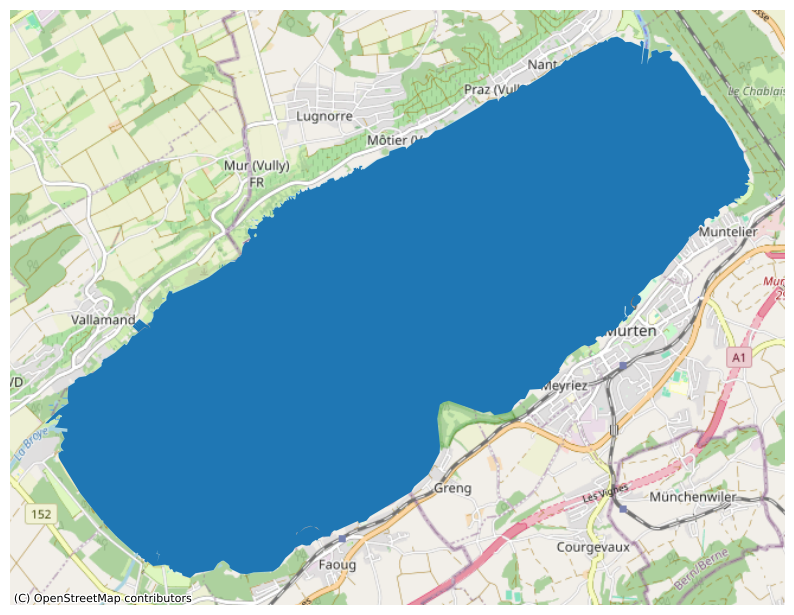

In [20]:
ax = lake_morat.to_crs(epsg=3857).plot(figsize=(10, 10)) # EPSG:3857 is the Web Mercator projection
ax.set_axis_off()
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [21]:
np.random.seed(123)

In [22]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

lake_morat = lake_morat.to_crs(epsg=2056)

minx, miny, maxx, maxy = lake_morat.total_bounds

n = 1000_000

x_coords = np.random.uniform(minx, maxx, n)
y_coords = np.random.uniform(miny, maxy, n)

points = gpd.points_from_xy(x_coords, y_coords)

points_gdf = gpd.GeoDataFrame(geometry=points, crs=2056)

inside_points = gpd.sjoin(points_gdf, lake_morat, predicate='within', how='inner')

estimated_area = inside_points.shape[0] / n * (maxx - minx) * (maxy - miny)

print("Total number of points: {:,}".format(n))
print("Number of points inside Lake Morat: "+ str(inside_points.shape[0])+ " (" + str(round(inside_points.shape[0]/n*100, 2)) + "%)")
print("Estimated area of Lake Morat:", estimated_area/10**6, "km²")
print("Error:", abs(lake_morat.to_crs(epsg=2056).area[0] - estimated_area)/10**6, "km²", "(" + str(round(abs(lake_morat.to_crs(epsg=2056).area[0] - estimated_area)/lake_morat.to_crs(epsg=2056).area[0]*100, 2)) + "%)")

Total number of points: 1,000,000
Number of points inside Lake Morat: 487556 (48.76%)
Estimated area of Lake Morat: 22.51093135571202 km²
Error: 0.013496141849197448 km² (0.06%)


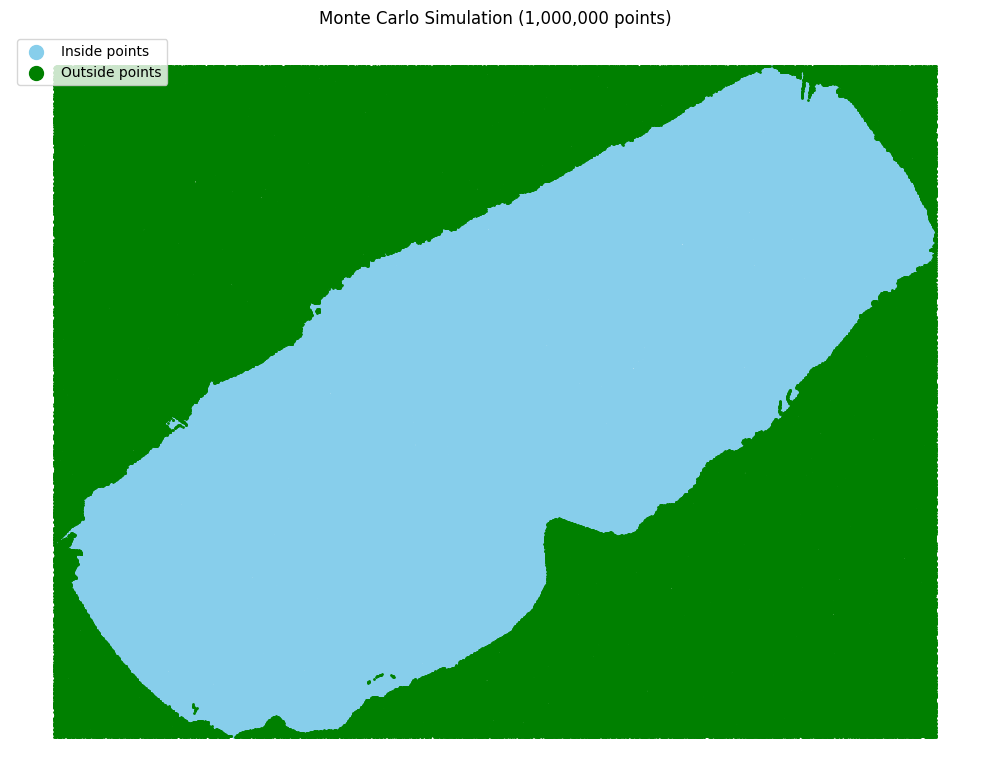

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
inside_points.plot(ax=ax, color='skyblue', markersize=1)
outside_points = points_gdf.loc[~points_gdf.index.isin(inside_points.index)]
outside_points.plot(ax=ax, color='green', markersize=1)
ax.set_axis_off()
ax.set_title("Monte Carlo Simulation (1,000,000 points)")
ax.legend(["Inside points", "Outside points"], loc='upper left', markerscale=10)
plt.tight_layout()


In [24]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from joblib import Parallel, delayed

lake_morat = lake_morat.to_crs(epsg=2056)

minx, miny, maxx, maxy = lake_morat.total_bounds

n_total = 10_000_000
batch_size = 100_000

lake_morat_sindex = lake_morat.sindex

def process_batch(minx, miny, maxx, maxy, batch_size):
    x_coords = np.random.uniform(minx, maxx, batch_size)
    y_coords = np.random.uniform(miny, maxy, batch_size)
    points = gpd.points_from_xy(x_coords, y_coords)
    
    batch_gdf = gpd.GeoDataFrame(geometry=points, crs=2056)
    
    inside_batch = batch_gdf.sjoin(lake_morat, predicate='within', how='inner')
    
    return inside_batch.shape[0]

n_batches = n_total // batch_size
results = Parallel(n_jobs=-1, backend='loky')(
    delayed(process_batch)(minx, miny, maxx, maxy, batch_size) for _ in range(n_batches)
)

total_inside = sum(results)

estimated_area = total_inside / n_total * (maxx - minx) * (maxy - miny)


print("Total number of points: {:,}".format(n_total))
print("Number of points inside Lake Morat: "+ str(total_inside)+ " (" + str(round(total_inside/n_total*100, 2)) + "%)")
print("Estimated area of Lake Morat:", estimated_area / 10**6, "km²")
print("Error:", abs(lake_morat.to_crs(epsg=2056).area[0] - estimated_area) / 10**6, "km²", "(" + str(round(abs(lake_morat.to_crs(epsg=2056).area[0] - estimated_area) / lake_morat.to_crs(epsg=2056).area[0] * 100, 2)) + "%)")


Total number of points: 10,000,000
Number of points inside Lake Morat: 4870268 (48.7%)
Estimated area of Lake Morat: 22.486497680660456 km²
Error: 0.010937533202368767 km² (0.05%)


In [25]:
lake_morat = lake_morat.to_crs(epsg=2056)

minx, miny, maxx, maxy = lake_morat.total_bounds

n_total = 100_000_000
batch_size = 1_000_000

lake_morat_sindex = lake_morat.sindex

def process_batch(minx, miny, maxx, maxy, batch_size):
    x_coords = np.random.uniform(minx, maxx, batch_size)
    y_coords = np.random.uniform(miny, maxy, batch_size)
    points = gpd.points_from_xy(x_coords, y_coords)
    
    batch_gdf = gpd.GeoDataFrame(geometry=points, crs=2056)
    
    inside_batch = batch_gdf.sjoin(lake_morat, predicate='within', how='inner')
    
    return inside_batch.shape[0]

n_batches = n_total // batch_size
results = Parallel(n_jobs=-1, backend='loky')(
    delayed(process_batch)(minx, miny, maxx, maxy, batch_size) for _ in range(n_batches)
)

total_inside = sum(results)

estimated_area = total_inside / n_total * (maxx - minx) * (maxy - miny)


print("Total number of points: {:,}".format(n_total))
print("Number of points inside Lake Morat: "+ str(total_inside)+ " (" + str(round(total_inside/n_total*100, 2)) + "%)")
print("Estimated area of Lake Morat:", estimated_area / 10**6, "km²")
print("Error:", abs(lake_morat.to_crs(epsg=2056).area[0] - estimated_area) / 10**6, "km²", "(" + str(round(abs(lake_morat.to_crs(epsg=2056).area[0] - estimated_area) / lake_morat.to_crs(epsg=2056).area[0] * 100, 3)) + "%)")


Total number of points: 100,000,000
Number of points inside Lake Morat: 48720609 (48.72%)
Estimated area of Lake Morat: 22.494775673101866 km²
Error: 0.00265954076096043 km² (0.012%)


# Creating HQ map without labels

In [26]:
# import geopandas as gpd
# import contextily as ctx
# import matplotlib.pyplot as plt
# import rasterio
# from rasterio.transform import from_bounds
# import numpy as np

# lake_morat_3857 = lake_morat.to_crs(epsg=3857)

# fig, ax = plt.subplots(figsize=(10, 10))
# lake_morat_3857.plot(ax=ax, color='blue', alpha=0, edgecolor='black')  # Adjust alpha and color as needed

# ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, zoom=16)

# ax.set_axis_off()

# fig.savefig("lake_morat_temp.png", dpi=900, bbox_inches='tight')
# plt.close(fig)

# with rasterio.open("lake_morat_temp.png") as img:
#     # Get the bounding box from the plotted axis
#     xmin, xmax = ax.get_xlim()
#     ymin, ymax = ax.get_ylim()
    
#     transform = from_bounds(xmin, ymin, xmax, ymax, img.width, img.height)

#     metadata = {
#         'driver': 'GTiff',
#         'height': img.height,
#         'width': img.width,
#         'count': 3,  # RGB channels
#         'dtype': 'uint8',
#         'crs': 'EPSG:3857',  # Web Mercator CRS
#         'transform': transform
#     }

#     with rasterio.open("lake_morat.tif", "w", **metadata) as dest:
#         for i in range(1, 4):  # RGB channels
#             dest.write(img.read(i), i)

# print("GeoTIFF saved as lake_morat.tif")
